In [1]:
import numpy as np
from keras import backend as K
from keras.engine.topology import Layer
import tensorly.backend as T

class pruned_Dense(Layer):
    def __init__(self, n_neurons_out, **kwargs):
        self.n_neurons_out = n_neurons_out
        super(pruned_Dense,self).__init__(**kwargs)

    def build(self, input_shape):
        #define the variables of this layer in the build function:
        n_neurons_in = input_shape[1]
        # print(n_neurons_in)
        # print(self.n_neurons_out)
        stdv = 1/np.sqrt(n_neurons_in)
        w = np.random.normal(size=[n_neurons_in, self.n_neurons_out], loc=0.0, scale=stdv).astype(np.float32)
        self.w = K.variable(w)
        b = np.zeros(self.n_neurons_out)
        self.b = K.variable(b)
        # w is the weight matrix, b is the bias. These are the trainable variables of this layer.
        self.trainable_weights = [self.w, self.b]
        # mask is a non-trainable weight that simulates pruning. the values of mask should be either 1 or 0, where 0 will prune a weight. We initialize mask to all ones:
        mask = np.ones((n_neurons_in, self.n_neurons_out))
        self.mask = K.variable(mask)

    def call(self, x):
        # define the input-output relationship in this layer in this function
        pruned_w = self.w * self.mask
        out = K.dot(x, pruned_w)
        out = out + self.b
        return out

    def compute_output_shape(self, input_shape):
        #define the shape of this layer's output:
        return (input_shape[0], self.n_neurons_out)

    def get_mask(self):
        #get the mask values
        return K.get_value(self.mask)

    def set_mask(self, mask):
        #set new mask values to this layer
        K.set_value(self.mask, mask)

Using TensorFlow backend.


In [22]:
a = torch.ones(5,4,2)
print(type(a))

<class 'torch.Tensor'>


In [23]:
modes=[2,3]
for index, mode in enumerate(modes):
    print(index)
    print(mode)

0
2
1
3


In [24]:
def partial_tucker(tensor, modes, rank=None, n_iter_max=100, init='svd', tol=10e-5,
                   svd='numpy_svd', random_state=None, verbose=False, ranks=None):
    """Partial tucker decomposition via Higher Order Orthogonal Iteration (HOI)

        Decomposes `tensor` into a Tucker decomposition exclusively along the provided modes.

    Parameters
    ----------
    tensor : ndarray
    modes : int list
            list of the modes on which to perform the decomposition
    ranks : None or int list
            size of the core tensor, ``(len(ranks) == len(modes))``
    rank : None or int
            number of components
    n_iter_max : int
                 maximum number of iteration
    init : {'svd', 'random'}, optional
    svd : str, default is 'numpy_svd'
        function to use to compute the SVD,
        acceptable values in tensorly.SVD_FUNS
    tol : float, optional
          tolerance: the algorithm stops when the variation in
          the reconstruction error is less than the tolerance
    random_state : {None, int, np.random.RandomState}
    verbose : int, optional
        level of verbosity

    Returns
    -------
    core : ndarray
            core tensor of the Tucker decomposition
    factors : ndarray list
            list of factors of the Tucker decomposition.
            with ``core.shape[i] == (tensor.shape[i], ranks[i]) for i in modes``

    """
    if ranks is not None:
        message = "'ranks' is depreciated, please use 'rank' instead"
        warnings.warn(message, DeprecationWarning)
        rank = ranks

    if rank is None:
        message = "No value given for 'rank'. The decomposition will preserve the original size."
        warnings.warn(message, Warning)
        rank = [tl.shape(tensor)[mode] for mode in modes]
    elif isinstance(rank, int):
        message = "Given only one int for 'rank' instead of a list of {} modes. Using this rank for all modes.".format(len(modes))
        warnings.warn(message, Warning)
        rank = [rank for _ in modes]

    try:
        svd_fun = tl.SVD_FUNS[svd]
    except KeyError:
        message = 'Got svd={}. However, for the current backend ({}), the possible choices are {}'.format(
                svd, tl.get_backend(), tl.SVD_FUNS)
        raise ValueError(message)

    # SVD init
    if init == 'svd':
        factors = []
        for index, mode in enumerate(modes):
            eigenvecs, _, _ = svd_fun(unfold(tensor, mode), n_eigenvecs=rank[index], random_state=random_state)
            factors.append(eigenvecs)
    else:
        rng = check_random_state(random_state)
        core = tl.tensor(rng.random_sample(rank), **tl.context(tensor))
        factors = [tl.tensor(rng.random_sample((tl.shape(tensor)[mode], rank[index])), **tl.context(tensor)) for (index, mode) in enumerate(modes)]

    rec_errors = []
    norm_tensor = tl.norm(tensor, 2)

    for iteration in range(n_iter_max):
        for index, mode in enumerate(modes):
            core_approximation = multi_mode_dot(tensor, factors, modes=modes, skip=index, transpose=True)
            eigenvecs, _, _ = svd_fun(unfold(core_approximation, mode), n_eigenvecs=rank[index], random_state=random_state)
            factors[index] = eigenvecs

        core = multi_mode_dot(tensor, factors, modes=modes, transpose=True)

        # The factors are orthonormal and therefore do not affect the reconstructed tensor's norm
        rec_error = sqrt(abs(norm_tensor**2 - tl.norm(core, 2)**2)) / norm_tensor
        rec_errors.append(rec_error)

        if iteration > 1:
            if verbose:
                print('reconstruction error={}, variation={}.'.format(
                    rec_errors[-1], rec_errors[-2] - rec_errors[-1]))

            if tol and abs(rec_errors[-2] - rec_errors[-1]) < tol:
                if verbose:
                    print('converged in {} iterations.'.format(iteration))
                break

    return core, factors

In [30]:
import tensorly as tl
from tensorly.base import unfold
from tensorly.tenalg import multi_mode_dot, mode_dot
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.random import check_random_state
from math import sqrt

import warnings

# Author: Jean Kossaifi <jean.kossaifi+tensors@gmail.com>

# License: BSD 3 clause


def partial_tucker(tensor, modes, rank=None, n_iter_max=100, init='svd', tol=10e-5,
                   svd='numpy_svd', random_state=None, verbose=False, ranks=None):
    """Partial tucker decomposition via Higher Order Orthogonal Iteration (HOI)
        Decomposes `tensor` into a Tucker decomposition exclusively along the provided modes.
    Parameters
    ----------
    tensor : ndarray
    modes : int list
            list of the modes on which to perform the decomposition
    ranks : None or int list
            size of the core tensor, ``(len(ranks) == len(modes))``
    rank : None or int
            number of components
    n_iter_max : int
                 maximum number of iteration
    init : {'svd', 'random'}, optional
    svd : str, default is 'numpy_svd'
        function to use to compute the SVD,
        acceptable values in tensorly.SVD_FUNS
    tol : float, optional
          tolerance: the algorithm stops when the variation in
          the reconstruction error is less than the tolerance
    random_state : {None, int, np.random.RandomState}
    verbose : int, optional
        level of verbosity
    Returns
    -------
    core : ndarray
            core tensor of the Tucker decomposition
    factors : ndarray list
            list of factors of the Tucker decomposition.
            with ``core.shape[i] == (tensor.shape[i], ranks[i]) for i in modes``
    """
    if ranks is not None:
        message = "'ranks' is depreciated, please use 'rank' instead"
        warnings.warn(message, DeprecationWarning)
        rank = ranks

    if rank is None:
        message = "No value given for 'rank'. The decomposition will preserve the original size."
        warnings.warn(message, Warning)
        rank = [tl.shape(tensor)[mode] for mode in modes]
    elif isinstance(rank, int):
        message = "Given only one int for 'rank' instead of a list of {} modes. Using this rank for all modes.".format(len(modes))
        warnings.warn(message, Warning)
        rank = [rank for _ in modes]

    try:
        svd_fun = tl.SVD_FUNS[svd]
    except KeyError:
        message = 'Got svd={}. However, for the current backend ({}), the possible choices are {}'.format(
                svd, tl.get_backend(), tl.SVD_FUNS)
        raise ValueError(message)

    # SVD init
    if init == 'svd':
        factors = []
        for index, mode in enumerate(modes):
            eigenvecs, _, _ = svd_fun(unfold(tensor, mode), n_eigenvecs=rank[index], random_state=random_state)
            factors.append(eigenvecs)
    else:
        rng = check_random_state(random_state)
        core = tl.tensor(rng.random_sample(rank), **tl.context(tensor))
        factors = [tl.tensor(rng.random_sample((tl.shape(tensor)[mode], rank[index])), **tl.context(tensor)) for (index, mode) in enumerate(modes)]

    rec_errors = []
    norm_tensor = tl.norm(tensor, 2)

    for iteration in range(n_iter_max):
        for index, mode in enumerate(modes):
            core_approximation = multi_mode_dot(tensor, factors, modes=modes, skip=index, transpose=True)
            eigenvecs, _, _ = svd_fun(unfold(core_approximation, mode), n_eigenvecs=rank[index], random_state=random_state)
            factors[index] = eigenvecs

        core = multi_mode_dot(tensor, factors, modes=modes, transpose=True)

        # The factors are orthonormal and therefore do not affect the reconstructed tensor's norm
        rec_error = sqrt(abs(norm_tensor**2 - tl.norm(core, 2)**2)) / norm_tensor
        rec_errors.append(rec_error)

        if iteration > 1:
            if verbose:
                print('reconstruction error={}, variation={}.'.format(
                    rec_errors[-1], rec_errors[-2] - rec_errors[-1]))

            if tol and abs(rec_errors[-2] - rec_errors[-1]) < tol:
                if verbose:
                    print('converged in {} iterations.'.format(iteration))
                break

    return core, factors

In [3]:
import tensorly as tl
import tensorflow as tf
import numpy as np
import math
from tensorly.decomposition import partial_tucker
from tensorly import tucker_to_tensor
import torch



def decomposer(test, R1, R2):
    print(test.shape)
    core, [I,O] = partial_tucker(test,ranks=[R1,R2], modes=[2,3])
    O = O.T
    modes=[2,3]
    reconstruct = np.zeros((test.shape[0],test.shape[1],test.shape[2],test.shape[3]))
    print('reconstructing')

    # The factors are orthonormal and therefore do not affect the reconstructed tensor's norm
    for i in range(0,core.shape[0]):
        for j in range(0,core.shape[1]):
            for k in range(0,core.shape[3]):
                reconstruct[i,j,:,k] = np.dot(I,core[i,j,:,k])

    for i in range(0,core.shape[0]):
        for j in range(0,core.shape[1]):
            for k in range(0,core.shape[2]):
                reconstruct[i,j,k,:] = np.dot(core[i,j,k,:],O)
    
    
    mse = np.linalg.norm(test-reconstruct)
    print(mse)
    return mse;


(3, 3, 64, 64)
reconstructing
204.85937212671615
(3, 3, 64, 64)
reconstructing
202.57129371485314
(3, 3, 64, 64)
reconstructing
200.53091630992841
(3, 3, 64, 64)
reconstructing
197.09174075955744
(3, 3, 64, 64)
reconstructing
196.3188495225574
(3, 3, 64, 64)
reconstructing
192.3429765169471
(3, 3, 64, 64)
reconstructing
190.93340220681756
(3, 3, 64, 64)
reconstructing
188.51049293813995
(3, 3, 64, 64)
reconstructing
188.48529459467392
(3, 3, 64, 64)
reconstructing
186.5655626088178
(3, 3, 64, 64)
reconstructing
182.94740706945893
(3, 3, 64, 64)
reconstructing
182.32493803289884
(3, 3, 64, 64)
reconstructing
178.8637911677515
(3, 3, 64, 64)
reconstructing
178.0407186355519
(3, 3, 64, 64)
reconstructing
176.2259777675497
(3, 3, 64, 64)
reconstructing
173.37691443515374
(3, 3, 64, 64)
reconstructing
172.74184926110226
(3, 3, 64, 64)
reconstructing
171.0008889960485
(3, 3, 64, 64)
reconstructing
171.02330073069118
(3, 3, 64, 64)
reconstructing
168.33695155854758
(3, 3, 64, 64)
reconstructi

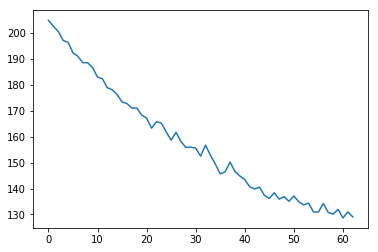

In [4]:
import matplotlib.pyplot as plt
import torch
import tensorly.backend as T

test = np.random.randn(3,3,64,64)
answer = []
for i in range(1,64):
    answer.append(decomposer(test,64,i))

plt.plot(answer)



(3, 3, 64, 64)
reconstructing
202.44636732640674
(3, 3, 64, 64)
reconstructing
197.394436831637
(3, 3, 64, 64)
reconstructing
193.48204127393763
(3, 3, 64, 64)
reconstructing
188.45616104507317
(3, 3, 64, 64)
reconstructing
184.9829148586245
(3, 3, 64, 64)
reconstructing
180.47453032991092
(3, 3, 64, 64)
reconstructing
178.0072100214704
(3, 3, 64, 64)
reconstructing
175.3454269629948
(3, 3, 64, 64)
reconstructing
169.87916250908935
(3, 3, 64, 64)
reconstructing
167.96250467808255
(3, 3, 64, 64)
reconstructing
162.47871212109774
(3, 3, 64, 64)
reconstructing
165.75579878537795
(3, 3, 64, 64)
reconstructing
159.14904917556495
(3, 3, 64, 64)
reconstructing
156.99181068089203
(3, 3, 64, 64)
reconstructing
153.7554482354649
(3, 3, 64, 64)
reconstructing
153.66543849212152
(3, 3, 64, 64)
reconstructing
151.60157701686333
(3, 3, 64, 64)
reconstructing
147.80580636013136
(3, 3, 64, 64)
reconstructing
147.13492245224236
(3, 3, 64, 64)
reconstructing
144.99905452688014
(3, 3, 64, 64)
reconstruct

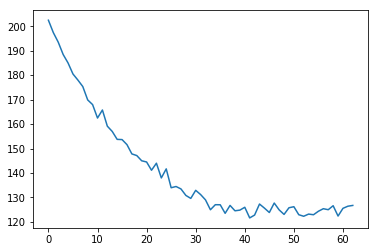

In [5]:
answer = []
for i in range(1,64):
    answer.append(decomposer(test,i,64))

plt.plot(answer)

In [3]:
from keras.datasets import cifar10
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

from keras.datasets import cifar10
from keras.utils import np_utils

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pickle

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
X_train /= 255
X_test /= 255
X_train=2*X_train-1
X_test=2*X_test-1

data_train = X_train
labels_train = Y_train
data_test = X_test
labels_test = Y_test
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

batch_size=100
lr=0.001
Training=True
Compressing=False

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:


def get_model():
	batch_norm_alpha=0.9
	batch_norm_eps=1e-4

	model=Sequential()

	model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3]))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

	model.add(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

	model.add(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	#model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

	model.add(Flatten())

	model.add(Dense(512))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Dense(512))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Dense(10))
	model.add(Activation('softmax'))

	return model


model=get_model()
for i in range(len(model.layers)):
 
    print(model.get_layer(index=i).output)

weights_path='pretrained_cifar10.h5'
model.load_weights(weights_path)
opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
#loss1 = tf.keras.losses.sparse_categorical_crossentropy()


model.compile(optimizer=opt, 
              loss="categorical_crossentropy" ,metrics=['accuracy'])
#history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)
scores_dropout_hidden = model.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))
#complie the model with sparse categorical crossentropy loss function as you did in part 1

#make sure weights are loaded correctly by evaluating the model here and printing the output




Tensor("conv2d_1/BiasAdd:0", shape=(?, 30, 30, 64), dtype=float32)
Tensor("activation_1/Relu:0", shape=(?, 30, 30, 64), dtype=float32)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 30, 30, 64), dtype=float32)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("activation_2/Relu:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("conv2d_3/BiasAdd:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("activation_3/Relu:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("batch_normalization_3/cond/Merge:0", shape=(?, 12, 12, 128), dtype=float32)
Tensor("conv2d_4/BiasAdd:0", shape=(?, 10, 10, 128), dtype=float32)
Tensor("activation_4/Relu:0", shape=(?, 10, 10, 128), dtype=float32)
Tensor("batch_normalization_4/cond/Merge:0", shape=(?, 10, 10, 128), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 5,

In [124]:
for i in model.layers:
    if type(i) == keras.layers.convolutional.Conv2D:
        print(type(i))
        print(i.get_weights()[0].shape)

<class 'keras.layers.convolutional.Conv2D'>
(3, 3, 3, 64)
<class 'keras.layers.convolutional.Conv2D'>
(3, 3, 64, 64)
<class 'keras.layers.convolutional.Conv2D'>
(3, 3, 64, 128)
<class 'keras.layers.convolutional.Conv2D'>
(3, 3, 128, 128)
<class 'keras.layers.convolutional.Conv2D'>
(3, 3, 128, 256)
<class 'keras.layers.convolutional.Conv2D'>
(3, 3, 256, 256)


In [ ]:
            weight = i.get_weights()
            print(weight[0].shape)
            biastemp = np.zeros(3)#np.zeros(weight[1].shape)
            loss, core, I, O = decompose(weight[0],[64,64])
            I = np.expand_dims(I, axis=0)
            I = np.expand_dims(I, axis=0)
            print(loss)
            
            first = 0;
            filtershape = int(i.kernel[0].shape[0])           #being used in 2nd layer , k 
            print(filtershape)
            print(i.filters)           
    
            print(layer1.set_weights([I,biastemp]))
            print(layer2.set_weights([core,biastemp]))
            print(layer3.set_weights(O))
            
                        
            print(dir(i))
            weight = i.get_weights()
            print(type(weight[0]))
            print(weight[0].shape)
            loss, core, I, O = decompose(weight[0],[64,64])

In [ ]:
            print('filter number:')
            print(i.filters)
            weight = i.get_weights()
            k,k,c,f = weight[0].shape;
            loss, core, I, O = decompose(weight[0],[22,21])
            O = O.T

            relativeweights.append(I);
            relativeweights.append(core)
            relativeweights.append(O)
            
            layer1 = Conv2D(filters=I.shape[1], kernel_size=1, strides=(1, 1), padding='valid',input_shape=[32,32,3])
            layer2 = Conv2D(filters=O.shape[0], kernel_size=i.kernel_size, strides=(1, 1), padding='valid')
            layer3 = Conv2D(filters=i.filters, kernel_size=1, strides=(1, 1), padding='valid')
            model2.add(layer1)
            model2.add(layer2)
            model2.add(layer3)

In [19]:
import tensorflow as tf
from tensorly.decomposition import partial_tucker
from tensorly.tenalg import multi_mode_dot, mode_dot

def decompose(value,rank):
    #value = tf.convert_to_tensor(value)
    core,[I,O] = partial_tucker(value,modes = [2,3],ranks = rank)
    #core = tf.convert_to_tensor(core)
    #I = tf.convert_to_tensor(I)
    #O = tf.convert_to_tensor(O)
    #reconstruct = tf.matmul(tf.matmul(I,core),O.T)
    reconstruct = np.zeros((value.shape[0],value.shape[1],value.shape[2],value.shape[3]))
    modes=[2,3]
    factors = [I,O]
    for i in range(0,core.shape[0]):
        for j in range(0,core.shape[1]):
            for k in range(0,core.shape[3]):
                reconstruct[i,j,:,k] = np.dot(I,core[i,j,:,k])

    for i in range(0,core.shape[0]):
        for j in range(0,core.shape[1]):
            for k in range(0,core.shape[2]):
                reconstruct[i,j,k,:] = np.dot(core[i,j,k,:],O.T)
    #for index, mode in enumerate(modes):
        #print(index)
        #print(modes)
        #if index - 1 == 0:
        #    core_approximation = multi_mode_dot(core, factors, modes=modes, skip=index, transpose=True)
        #    print(core_approximation.shape)
        #else:
        #    core_approximation = multi_mode_dot(core, factors, modes=modes, skip=index, transpose=False)
        #    print(core_approximation.shape)
    
    return np.linalg.norm(value-reconstruct), core, I, O 

In [23]:
def convert_to_masked_model(model,kval):
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    relativeweights = []
    model2=Sequential()
    first = 1;
    for i in model.layers:
        #if type(i) == keras.layers.convolutional.Conv2D:
        #if type(i) == keras.layers.core.Dense:
        if type(i) != keras.layers.convolutional.Conv2D:
            model2.add(i)
        elif type(i) == keras.layers.convolutional.Conv2D and first == 1:
            model2.add(i)
            first = 0;
        else:
            weight = i.get_weights()

            k,k,c,f = weight[0].shape;
            R1 = int(c*kval/8)
            R2 = int(f*kval/8)
            print('R1 & R2 ' + str(R1)+' and ' + str(R2))
            loss, core, I, O = decompose(weight[0],[R1,R2])
            O = O.T
            relativeweights.append(I);
            relativeweights.append(core)
            relativeweights.append(O)
            
            layer1 = Conv2D(filters=I.shape[1], kernel_size=1, strides=(1, 1), padding='valid')
            layer2 = Conv2D(filters=O.shape[0], kernel_size=i.kernel_size, strides=(1, 1), padding='valid')
            layer3 = Conv2D(filters=i.filters, kernel_size=1, strides=(1, 1), padding='valid')
            model2.add(layer1)
            model2.add(layer2)
            model2.add(layer3)
            
    
    return model2, relativeweights
k = 1
test,relativeweights = convert_to_masked_model(model,k)
print(len(relativeweights))

R1 & R2 8 and 8
R1 & R2 8 and 16
R1 & R2 16 and 16
R1 & R2 16 and 32
R1 & R2 32 and 32
15


In [24]:
def weightsetter(model, relativeweights):
    index = 0
    first = 1;
    for i in model.layers:
        if type(i) == keras.layers.convolutional.Conv2D :
            if first == 1:
                first = 0
                continue;
            if len(relativeweights[index].shape)>3:
                kernel = relativeweights[index]

                bias = np.zeros(kernel.shape[3])
                i.set_weights([kernel,bias])
                index = index+1;
            else:
                kernel = relativeweights[index]

                kernel = relativeweights[index]
                bias = np.zeros(kernel.shape[1])

                kernel = np.expand_dims(kernel, axis=0)
                kernel = np.expand_dims(kernel, axis=0)

                i.set_weights([kernel,bias])
                index = index+1;
    return model



In [25]:
opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
test.compile(optimizer=opt, 
                  loss="categorical_crossentropy" ,metrics=['accuracy'])
for i in test.layers:
    if type(i) == keras.layers.convolutional.Conv2D:
        print(i.get_weights()[0].shape)
test = weightsetter(test,relativeweights)
scores_dropout_hidden = test.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

(3, 3, 3, 64)
(1, 1, 64, 8)
(3, 3, 8, 8)
(1, 1, 8, 64)
(1, 1, 64, 8)
(3, 3, 8, 16)
(1, 1, 16, 128)
(1, 1, 128, 16)
(3, 3, 16, 16)
(1, 1, 16, 128)
(1, 1, 128, 16)
(3, 3, 16, 32)
(1, 1, 32, 256)
(1, 1, 256, 32)
(3, 3, 32, 32)
(1, 1, 32, 256)
10000/10000 [==============================] - 26s 3ms/step
Accuracy: 11.72%


In [26]:
for k in range(1,8):
    print('k value: ' +str(k))
    test,relativeweights = convert_to_masked_model(model,k)
    opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
    test.compile(optimizer=opt, 
                  loss="categorical_crossentropy" ,metrics=['accuracy'])
    test = weightsetter(test,relativeweights)
    scores_dropout_hidden = test.evaluate(data_test, labels_test)
    print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

k value: 1
R1 & R2 8 and 8
R1 & R2 8 and 16
R1 & R2 16 and 16
R1 & R2 16 and 32
R1 & R2 32 and 32
10000/10000 [==============================] - 27s 3ms/step
Accuracy: 11.72%
k value: 2
R1 & R2 16 and 16
R1 & R2 16 and 32
R1 & R2 32 and 32
R1 & R2 32 and 64
R1 & R2 64 and 64
10000/10000 [==============================] - 29s 3ms/step
Accuracy: 50.15%
k value: 3
R1 & R2 24 and 24
R1 & R2 24 and 48
R1 & R2 48 and 48
R1 & R2 48 and 96
R1 & R2 96 and 96
10000/10000 [==============================] - 32s 3ms/step
Accuracy: 77.66%
k value: 4
R1 & R2 32 and 32
R1 & R2 32 and 64
R1 & R2 64 and 64
R1 & R2 64 and 128
R1 & R2 128 and 128
10000/10000 [==============================] - 48s 5ms/step
Accuracy: 84.23%
k value: 5
R1 & R2 40 and 40
R1 & R2 40 and 80
R1 & R2 80 and 80
R1 & R2 80 and 160
R1 & R2 160 and 160
10000/10000 [==============================] - 58s 6ms/step
Accuracy: 88.17%
k value: 6
R1 & R2 48 and 48
R1 & R2 48 and 96
R1 & R2 96 and 96
R1 & R2 96 and 192
R1 & R2 192 and 192
100

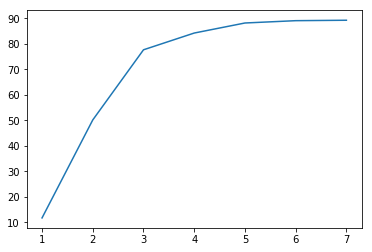

In [27]:
ans = [11.72,50.15,77.66,84.23,88.17,89.08,89.25]
xaxis = [1,2,3,4,5,6,7]
plt.plot(xaxis,ans)

In [160]:
for i in test.layers:
    print(type(i))

<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.pooling.MaxPooling2D'>
<cla

In [125]:
for i in relativeweights:
    print(i.shape)

(3, 3)
(3, 3, 3, 64)
(64, 64)
(64, 64)
(3, 3, 64, 64)
(64, 64)
(64, 64)
(3, 3, 64, 64)
(64, 128)
(128, 64)
(3, 3, 64, 64)
(64, 128)
(128, 64)
(3, 3, 64, 64)
(64, 256)
(256, 64)
(3, 3, 64, 64)
(64, 256)
